In [1]:
from fitter import Fitter, get_common_distributions, get_distributions
import os
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
import statsmodels
import statsmodels.api as sm
import seaborn as sns
import sqlalchemy
import psycopg_binary

In [2]:
def append_percentage(x, pos):
    del pos
    return str(int(x))+str('%')

def formatter(x, pos):
    del pos
    return str(int(x*100))+str('%')

In [3]:
# sns.set(
#     context="paper",
#     style="darkgrid",
#     palette="pastel",
#     rc={"figure.dpi": 150}
# )
sns.set_context("paper", font_scale=1.5)

In [4]:
def use_fitter(data):
    # Initialize the fitter object
    # f = Fitter(data, distributions='common')
    f = Fitter(data)

    # Fit common distributions
    f.fit(get_common_distributions())

    # Print the summary of the fitted distributions
    print(f.summary())

    print (f.get_best(method = 'sumsquare_error'))
    print (f.get_best(method = 'aic'))
    print (f.get_best(method = 'bic'))
    # print (f.get_best(method = 'kl_div'))
    print (f.get_best(method = 'ks_statistic'))
    print (f.get_best(method = 'ks_pvalue'))

In [5]:
def remove_outlier(data, contamination=0.1):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    yhat = lof.fit_predict(data)
    mask = yhat != -1
    return data[mask]

# TOOD and PFET

## Load TOOD maintained

In [6]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "time-out-of-date-from-db"), "time_out_of_date_combined_maintained.csv")
print (data_file)
df_tood = pd.read_csv(data_file,
                header=0,
                sep=';',
                on_bad_lines='skip',
                usecols=['system_name', 'total_duration', 'out_of_date_duration', 'ratio', 'avg_total_duration', 'avg_out_of_date_duration', 'avg_ratio'],
                )
# df.columns = ['system_name', 'package_name', 'total_requirement_duration', 'out_of_date_duration', 'ratio', 'dependents_approx']
rows = df_tood.shape[0]
print (df_tood.shape)
display(df_tood.head())

/Users/imranur/Research/security-metrics/code/visualize-data/../../data/time-out-of-date-from-db/time_out_of_date_combined_maintained.csv
(1505261, 7)


,system_name,total_duration,out_of_date_duration,ratio,avg_total_duration,avg_out_of_date_duration,avg_ratio
0,CARGO,310,0,0.000000,310.0,0.0,0.000000
1,CARGO,1650,1491,0.903636,1650.0,1491.0,0.903636
2,CARGO,3207,1111,0.346430,1603.5,555.5,0.346430
3,CARGO,198,15,0.075758,198.0,15.0,0.075758
4,CARGO,2407,0,0.000000,2407.0,0.0,0.000000


In [7]:
df_tood = df_tood.dropna()

In [8]:
df_tood.groupby(by=['system_name']).describe()

total_duration                                                  \
                     count         mean           std  min     25%     50%   
system_name                                                                  
CARGO               9690.0  1174.342105   1602.955742  1.0   249.0   708.0   
NPM              1366592.0  6166.020221  13331.488031  1.0  1129.0  2746.0   
PYPI              128979.0  2077.980144   3639.601646  1.0   459.0  1122.0   

                                out_of_date_duration               ...  \
                 75%        max                count         mean  ...   
system_name                                                        ...   
CARGO        1498.75    26724.0               9690.0   301.199690  ...   
NPM          6679.00  1464449.0            1366592.0  3039.263256  ...   
PYPI         2365.00   182267.0             128979.0   417.978524  ...   

            avg_out_of_date_duration               avg_ratio            \
                                 75%          max      count      mean   
system_name                                                              
CARGO                     137.000000  2594.000000     9690.0  0.210063   
NPM                       910.918269  4495.333333  1366592.0  0.396903   
PYPI                       42.818182  3438.500000   128979.0  0.141889   

                                                          
                  std  min  25%       50%       75%  max  
system_name                                               
CARGO        0.319871  0.0  0.0  0.000000  0.345361  1.0  
NPM          0.339070  0.0  0.0  0.374628  0.665698  1.0  
PYPI         0.274006  0.0  0.0  0.000000  0.136610  1.0  

[3 rows x 48 columns]

In [43]:
print(df_tood.groupby(by=['system_name'])['avg_out_of_date_duration'].describe().to_latex(columns=['count', 'mean', 'std', 'min', 'max'], float_format="%.0f", bold_rows=False, label="tab:statistics", caption="Statistics of the average post-fix exposure time per system."))

\begin{table}
\caption{Statistics of the average post-fix exposure time per system.}
\label{tab:statistics}
\begin{tabular}{lrrrrr}
\toprule
 & count & mean & std & min & max \\
system_name &  &  &  &  &  \\
\midrule
CARGO & 9690 & 166 & 357 & 0 & 2594 \\
NPM & 1366592 & 582 & 743 & 0 & 4495 \\
PYPI & 128979 & 109 & 284 & 0 & 3438 \\
\bottomrule
\end{tabular}
\end{table}



## Load PFET maintained

In [9]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "post-fix-exposure-time-from-db"), "post_fix_exposure_time_combined_maintained.csv")
print (data_file)
df_pfet = pd.read_csv(data_file,
                header=0,
                sep=';',
                on_bad_lines='skip',
                usecols=['system_name', 'total_duration', 'total_post_fix_exposure_time', 'ratio', 'avg_total_duration', 'avg_post_fix_exposure_time', 'avg_ratio'],
                )
# df.columns = ['system_name', 'package_name', 'total_requirement_duration', 'post_fix_exposure_time', 'ratio', 'dependents_approx']
rows = df_pfet.shape[0]
print (df_pfet.shape)
display(df_pfet.head())

/Users/imranur/Research/security-metrics/code/visualize-data/../../data/post-fix-exposure-time-from-db/post_fix_exposure_time_combined_maintained.csv
(224553, 7)


,system_name,total_duration,total_post_fix_exposure_time,ratio,avg_total_duration,avg_post_fix_exposure_time,avg_ratio
0,CARGO,375,93,0.248000,375.0,93.0,0.248000
1,CARGO,1219,549,0.450369,1219.0,549.0,0.450369
2,CARGO,187,187,1.000000,187.0,187.0,1.000000
3,CARGO,826,246,0.297821,826.0,246.0,0.297821
4,CARGO,1319,549,0.416224,1319.0,549.0,0.416224


In [10]:
df_pfet = df_pfet.dropna()

In [11]:
df_pfet.groupby(by=['system_name']).describe()

total_duration                                                   \
                     count         mean          std   min      25%     50%   
system_name                                                                   
CARGO                313.0  1106.038339   855.251091  23.0   467.00   944.0   
NPM               219310.0  2610.268100  2550.763285   1.0  1189.00  2002.0   
PYPI                4930.0  1207.042596  1168.258699   1.0   540.25   907.0   

                               total_post_fix_exposure_time               ...  \
                 75%       max                        count         mean  ...   
system_name                                                               ...   
CARGO        1496.00    5243.0                        313.0   386.376997  ...   
NPM          3028.00  113288.0                     219310.0  1386.048206  ...   
PYPI         1504.25   16391.0                       4930.0   559.637323  ...   

            avg_post_fix_exposure_time         avg_ratio                      \
                                   75%     max     count      mean       std   
system_name                                                                    
CARGO                            615.0  2545.0     313.0  0.345964  0.239240   
NPM                             1256.0  4295.0  219310.0  0.550687  0.270574   
PYPI                             621.0  3301.0    4930.0  0.508625  0.326434   

                                                          
                  min       25%       50%       75%  max  
system_name                                               
CARGO        0.001576  0.151951  0.340076  0.446961  1.0  
NPM          0.000267  0.333333  0.559471  0.755079  1.0  
PYPI         0.000548  0.200685  0.499059  0.800511  1.0  

[3 rows x 48 columns]

In [44]:
print(df_pfet.groupby(by=['system_name'])['avg_post_fix_exposure_time'].describe().to_latex(columns=['count', 'mean', 'std', 'min', 'max'], float_format="%.0f", bold_rows=False, label="tab:statistics", caption="Statistics of the average post-fix exposure time per system."))

\begin{table}
\caption{Statistics of the average post-fix exposure time per system.}
\label{tab:statistics}
\begin{tabular}{lrrrrr}
\toprule
 & count & mean & std & min & max \\
system_name &  &  &  &  &  \\
\midrule
CARGO & 313 & 366 & 422 & 2 & 2545 \\
NPM & 219310 & 962 & 684 & 1 & 4295 \\
PYPI & 4930 & 436 & 425 & 1 & 3301 \\
\bottomrule
\end{tabular}
\end{table}



# Load TOOD of critical projects

In [13]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "time-out-of-date-from-db"), "tofd_of_critical.csv")
print (data_file)
df_tood_critical = pd.read_csv(data_file,
                header=0,
                sep=';',
                on_bad_lines='skip',
                usecols=['system_name', 'from_package_name', 'avg_total_duration', 'avg_out_of_date_duration', 'avg_ratio', 'pagerank'],
                )
rows = df_tood_critical.shape[0]
print (df_tood_critical.shape)
display(df_tood_critical.head())

/Users/imranur/Research/security-metrics/code/visualize-data/../../data/time-out-of-date-from-db/tofd_of_critical.csv
(1292, 6)


,system_name,from_package_name,avg_out_of_date_duration,avg_total_duration,avg_ratio,pagerank
0,CARGO,actix,0.0,750.666667,0.00000,1.499950
1,CARGO,actix-rt,0.0,582.000000,0.00000,0.970717
2,CARGO,actix-service,0.0,801.000000,0.00000,0.753219
3,CARGO,actix-web,0.0,555.571429,0.00000,3.058886
4,CARGO,addr2line,54.5,332.500000,0.16391,2.635293


In [14]:
df_tood_critical.groupby(by=['system_name']).describe()

avg_out_of_date_duration                                     \
                               count        mean         std  min   25%   
system_name                                                               
CARGO                          228.0  156.220175  384.231138  0.0   0.0   
NPM                            777.0  500.029018  718.747090  0.0  39.8   
PYPI                           287.0   30.957776   90.478350  0.0   0.0   

                                            avg_total_duration               \
                    50%         75%     max              count         mean   
system_name                                                                   
CARGO          0.000000  107.125000  2576.0              228.0  1060.694439   
NPM          240.142857  616.666667  4397.0              777.0  1729.445759   
PYPI           0.000000    9.466667   641.0              287.0  1249.954290   

             ... avg_ratio      pagerank                                      \
             ...       75%  max    count        mean          std        min   
system_name  ...                                                               
CARGO        ...  0.160091  1.0    228.0   18.804865    73.293665   0.675651   
NPM          ...  0.401614  1.0    777.0  551.580608  1578.778764  80.865987   
PYPI         ...  0.010262  1.0    287.0    3.604150     7.320342   0.789371   

                                                               
                    25%         50%         75%           max  
system_name                                                    
CARGO          1.114322    2.235421    7.646570    627.581025  
NPM          115.130313  195.513687  398.613347  24944.117562  
PYPI           1.032407    1.556432    3.148657     78.351441  

[3 rows x 32 columns]

/var/folders/gq/329v3h5j3lv50j_25gdv3d8m0000gq/T/ipykernel_56025/1797519437.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_tood_critical, x='avg_out_of_date_duration', y='system_name', inner='quartile',


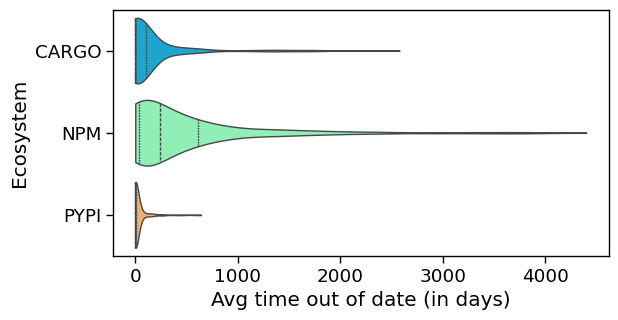

In [15]:
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.violinplot(data=df_tood_critical, x='avg_out_of_date_duration', y='system_name', inner='quartile',
                    palette='rainbow', cut=0)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "critical-projects"), "tood.pdf")

ax.set_xlabel('Avg time out of date (in days)')
ax.set_ylabel('Ecosystem')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

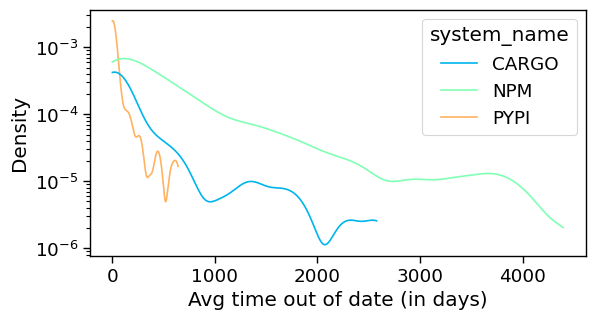

In [16]:
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.kdeplot(data=df_tood_critical, x='avg_out_of_date_duration', hue='system_name',
                palette='rainbow', cut=0)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "critical-projects"), "tood_kde.pdf")

ax.set_ylabel('Density')
ax.set_xlabel('Avg time out of date (in days)')
ax.set_yscale('log')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

/var/folders/gq/329v3h5j3lv50j_25gdv3d8m0000gq/T/ipykernel_56025/1485200465.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_tood_critical, x='avg_ratio', y='system_name', inner='quartile', palette='rainbow', cut=0)


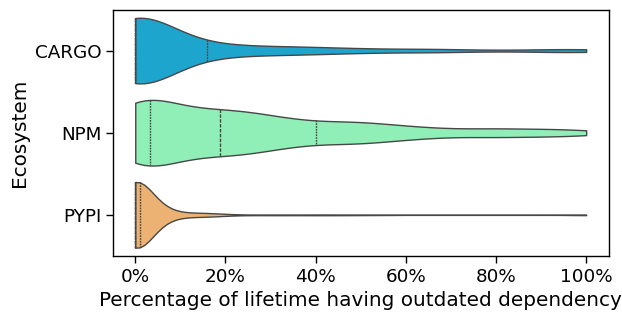

In [17]:
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.violinplot(data=df_tood_critical, x='avg_ratio', y='system_name', inner='quartile', palette='rainbow', cut=0)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "critical-projects"), "tood_ratio.pdf")

ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Ecosystem')
ax.set_xlabel('Percentage of lifetime having outdated dependency')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

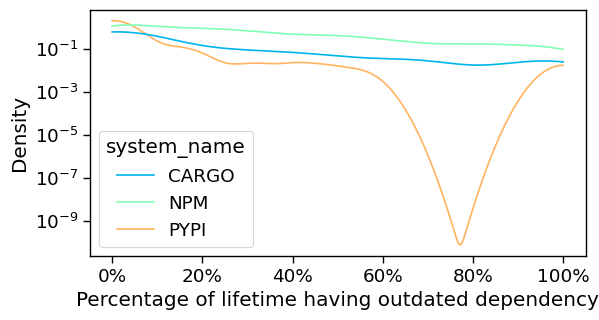

In [18]:
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.kdeplot(data=df_tood_critical, x='avg_ratio', hue='system_name', palette='rainbow', cut=0)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "critical-projects"), "tood_ratio_kde.pdf")

ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Density')
ax.set_xlabel('Percentage of lifetime having outdated dependency')
ax.set_yscale('log')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

# Load PFET of critical projects

In [20]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "post-fix-exposure-time-from-db"), "pfet_of_critical.csv")
print (data_file)
df_pfet_critical = pd.read_csv(data_file,
                header=0,
                sep=';',
                on_bad_lines='skip',
                usecols=['system_name', 'from_package_name', 'avg_total_duration', 'avg_post_fix_exposure_time', 'avg_ratio', 'pagerank'],
                )
rows = df_pfet_critical.shape[0]
print (df_pfet_critical.shape)
display(df_pfet_critical.head())

/Users/imranur/Research/security-metrics/code/visualize-data/../../data/post-fix-exposure-time-from-db/pfet_of_critical.csv
(1292, 6)


,system_name,from_package_name,avg_post_fix_exposure_time,avg_total_duration,avg_ratio,pagerank
0,CARGO,actix,0.0,750.666667,0.0,1.499950
1,CARGO,actix-rt,0.0,582.000000,0.0,0.970717
2,CARGO,actix-service,0.0,801.000000,0.0,0.753219
3,CARGO,actix-web,0.0,555.571429,0.0,3.058886
4,CARGO,addr2line,0.0,332.500000,0.0,2.635293


In [21]:
df_pfet_critical.groupby(by=['system_name']).describe()

avg_post_fix_exposure_time                                        \
                                 count       mean         std  min  25%  50%   
system_name                                                                    
CARGO                            228.0   3.853070   54.968606  0.0  0.0  0.0   
NPM                              777.0  21.489160  140.752965  0.0  0.0  0.0   
PYPI                             287.0   0.326605    5.083889  0.0  0.0  0.0   

                         avg_total_duration               ... avg_ratio  \
             75%     max              count         mean  ...       75%   
system_name                                               ...             
CARGO        0.0   829.0              228.0  1060.694439  ...       0.0   
NPM          0.0  2554.0              777.0  1729.445759  ...       0.0   
PYPI         0.0    86.0              287.0  1249.954290  ...       0.0   

                      pagerank                                      \
                  max    count        mean          std        min   
system_name                                                          
CARGO        0.299062    228.0   18.804865    73.293665   0.675651   
NPM          0.625615    777.0  551.580608  1578.778764  80.865987   
PYPI         0.704918    287.0    3.604150     7.320342   0.789371   

                                                               
                    25%         50%         75%           max  
system_name                                                    
CARGO          1.114322    2.235421    7.646570    627.581025  
NPM          115.130313  195.513687  398.613347  24944.117562  
PYPI           1.032407    1.556432    3.148657     78.351441  

[3 rows x 32 columns]

/var/folders/gq/329v3h5j3lv50j_25gdv3d8m0000gq/T/ipykernel_56025/3001172964.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_pfet_critical, x='avg_post_fix_exposure_time', y='system_name', inner='quartile',


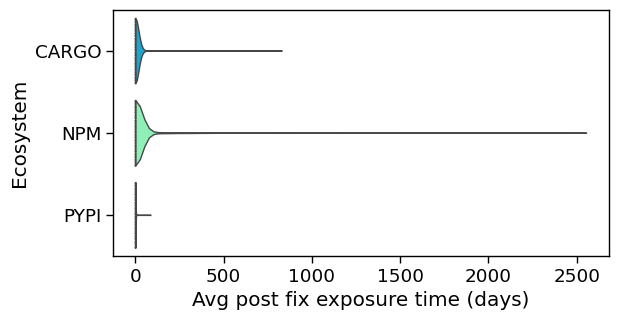

In [22]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "critical-projects"), "pfet.pdf")
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.violinplot(data=df_pfet_critical, x='avg_post_fix_exposure_time', y='system_name', inner='quartile',
                    palette='rainbow', cut=0)

ax.set_xlabel('Avg post fix exposure time (days)')
ax.set_ylabel('Ecosystem')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

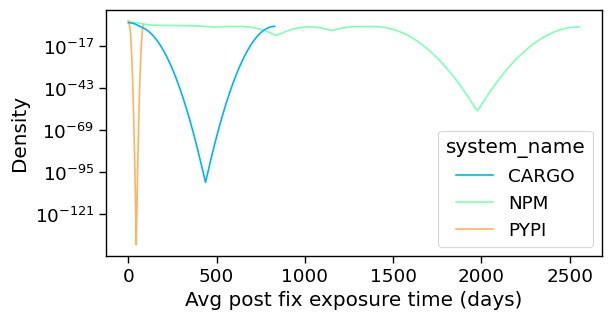

In [23]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "critical-projects"), "pfet_kde.pdf")
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.kdeplot(data=df_pfet_critical, x='avg_post_fix_exposure_time', hue='system_name',
                palette='rainbow', cut=0)

ax.set_ylabel('Density')
ax.set_xlabel('Avg post fix exposure time (days)')
ax.set_yscale('log')
plt.savefig(data_file, bbox_inches='tight')

/var/folders/gq/329v3h5j3lv50j_25gdv3d8m0000gq/T/ipykernel_56025/2493733071.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_pfet_critical, x='avg_ratio', y='system_name', inner='quartile', palette='rainbow', cut=0)


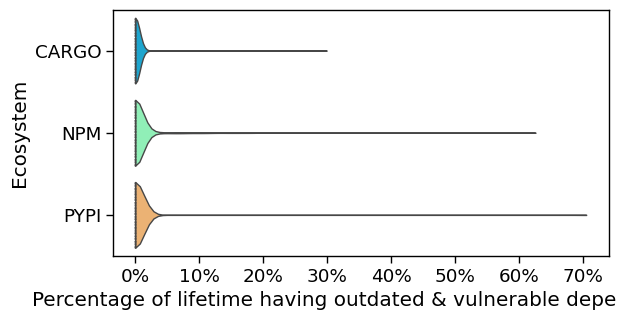

In [24]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "critical-projects"), "pfet_ratio.pdf")
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.violinplot(data=df_pfet_critical, x='avg_ratio', y='system_name', inner='quartile', palette='rainbow', cut=0)

ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Ecosystem')
ax.set_xlabel('Percentage of lifetime having outdated & vulnerable dependency')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

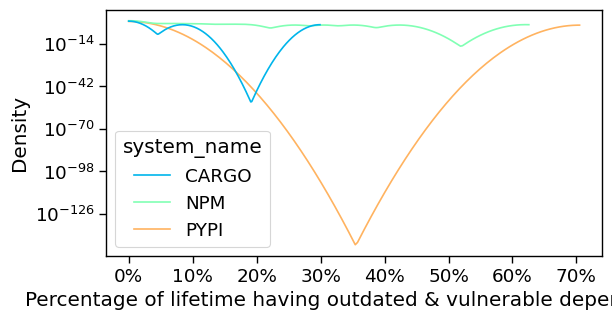

In [25]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "critical-projects"), "pfet_ratio_kde.pdf")
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.kdeplot(data=df_pfet_critical, x='avg_ratio', hue='system_name', palette='rainbow', cut=0)

ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Density')
ax.set_xlabel('Percentage of lifetime having outdated & vulnerable dependency')
ax.set_yscale('log')
plt.savefig(data_file, bbox_inches='tight')